In [1]:
import json
import numpy as np
from glob import glob
from copy import deepcopy
import os

In [131]:
with open('/mnt/sdb1/home/kbotashev/mip-nerf_projects/gaussian_splatting_original/gaussian-splatting/output/3DGS_data_planck_1211_van/adjusted_cameras_train.txt') as f:
    traj = f.readlines()

In [143]:
traj[0].split('\n')[0].split(' ')[2:6]
traj[0].split('\n')[0].split(' ')[6:]

['1.4452338218688965', '0.38011404871940613', '9.376884460449219']

In [147]:
[1,2,3,4,5,6,7][4:]

[5, 6, 7]

In [2]:
path = '/mnt/sdb1/home/kbotashev/3DGS/gaussian-splatting-lightning/renders/reception_van_render_circle_2_small.json'
images = sorted(glob(path.replace('json', 'mp4_frames') + '/*'))
with open(path) as f:
    traj = json.load(fp = f)   
camera_traj = traj['camera_path']
# for id, cam_info in enumerate(camera_traj):
#     R = np.array(cam_info['camera_to_world']).reshape(4,4)[:-1,:-1]
#     t = np.array(cam_info['camera_to_world']).reshape(4,4)[:-1,-1]
#     fovx, fovy = np.deg2rad(cam_info['fov']), np.deg2rad(cam_info['fov'])
#     image = images[id]

    # Camera(colmap_id=id, R=R, T=t, 
    #               FoVx=cam_info.FovX, FoVy=cam_info.FovY, 
    #               image=image, gt_alpha_mask=None,
    #               image_name=cam_info.image_name, uid=id, data_device=args.data_device)


In [3]:
new_traj = deepcopy(traj)

In [4]:
new_path = '/mnt/sdb1/home/kbotashev/cvpr_paper/outputs/output/data_nerf_synthetic_hq_reception_mupltiple_gaussian_splatting_pa/adjusted_cameras_testreception_van_render_circle_2_small_final.txt'

In [5]:
def qtvec_to_T(qtvec):
    T = np.eye(4)
    qvec = qtvec[:4]
    tvec = qtvec[4:]
    R = qvec2rotmat(qvec)
    T[:-1,:-1] = R
    T[:-1, -1] = tvec
    return np.linalg.inv(T)

def rot_t_to_T(t, R):
    T = np.eye(4)
    T[:-1,:-1] = R
    T[:-1, -1] = t
    return np.linalg.inv(T)

def read_json_poses(file_path):
    # Opening JSON file
    with open(file_path) as f:
        data = json.load(f)
    traj = {pose_info['img_name'] : rot_t_to_T(np.array(pose_info['position'], dtype=np.float64),
                                               np.array(pose_info['rotation'], dtype=np.float64)) for pose_info in data}
    return traj

def read_txt_poses(file_path):
    with open(file_path) as file:
        adj_train_traj_raw = file.readlines()

    adj_train_traj = [line.split('\n')[0].split(' ')[1:] for line in  adj_train_traj_raw]
    adj_train_traj_dict = {line_list[0] : qtvec_to_T(np.array(line_list[1:], dtype=np.float64)) for line_list in adj_train_traj}
    return adj_train_traj_dict

def qvec2rotmat(qvec):
    return np.array([
        [
            1 - 2 * qvec[2]**2 - 2 * qvec[3]**2,
            2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
            2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2]
        ], [
            2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
            1 - 2 * qvec[1]**2 - 2 * qvec[3]**2,
            2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1]
        ], [
            2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
            2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
            1 - 2 * qvec[1]**2 - 2 * qvec[2]**2
        ]
    ])

In [6]:
new_traj_dict = read_txt_poses(new_path)

In [7]:
new_traj.keys()

dict_keys(['keyframes', 'camera_type', 'render_height', 'render_width', 'fps', 'seconds', 'is_cycle', 'smoothness_value', 'orientation_transform', 'enable_transform', 'background_color', 'sh_degree', 'camera_path'])

In [8]:
new_traj['render_height'] = 1080
new_traj['render_width'] = 1920

In [9]:
savedir = '/mnt/sdb1/home/kbotashev/3DGS/gaussian-splatting-lightning/camera_paths'

In [10]:
with open(os.path.join(savedir, "van_traj.json"), "w") as outfile:
    json.dump(new_traj, outfile)

In [11]:
for i, img_id in enumerate(sorted(new_traj_dict.keys())):
    new_T = ((new_traj_dict[img_id])@np.diag([1,-1,-1,1])).reshape(-1).tolist()
    new_traj['camera_path'][i]['camera_to_world'] = new_T

In [12]:
with open(os.path.join(savedir, "pa_traj.json"), "w") as outfile:
    json.dump(new_traj, outfile)

In [6]:
from general_utils import get_expon_lr_func
import matplotlib.pyplot as plt

In [119]:
pose_init_lr = 1e-3
pose_final_lr = 1e-6
pose_decay_ratio = 0.2
pose_length = 1000

gaussians_init_lr = 1e-3
gaussians_final_lr = 1e-8
gaussians_decay_ratio = 0.4
gaussians_length = 2000

max_steps = 40000


In [124]:
num_subiterations = math.ceil(max_steps/(pose_length+gaussians_length))

In [123]:
import math

In [125]:
num_subiterations

14

In [107]:
pose_lrs = []
gaussians_lrs = []
curr_peak_pose_lr = pose_init_lr
curr_peak_gaussians_lr = gaussians_init_lr

for subiteration in range(int(num_subiterations)):
    pose_lr_funct = get_expon_lr_func(curr_peak_pose_lr, 1e-6, 20, 0, pose_length)
    gaussians_lr_funct = get_expon_lr_func(curr_peak_gaussians_lr, 1e-6, 20, 0, gaussians_length)
    pose_lrs += [0]*gaussians_length
    pose_lrs += [pose_lr_funct(it) for it in range(pose_length)]
    gaussians_lrs += [gaussians_lr_funct(it) for it in range(gaussians_length)]
    gaussians_lrs += [0]*pose_length
    curr_peak_pose_lr *= 1 - pose_decay_ratio
    curr_peak_gaussians_lr *= 1 - gaussians_decay_ratio

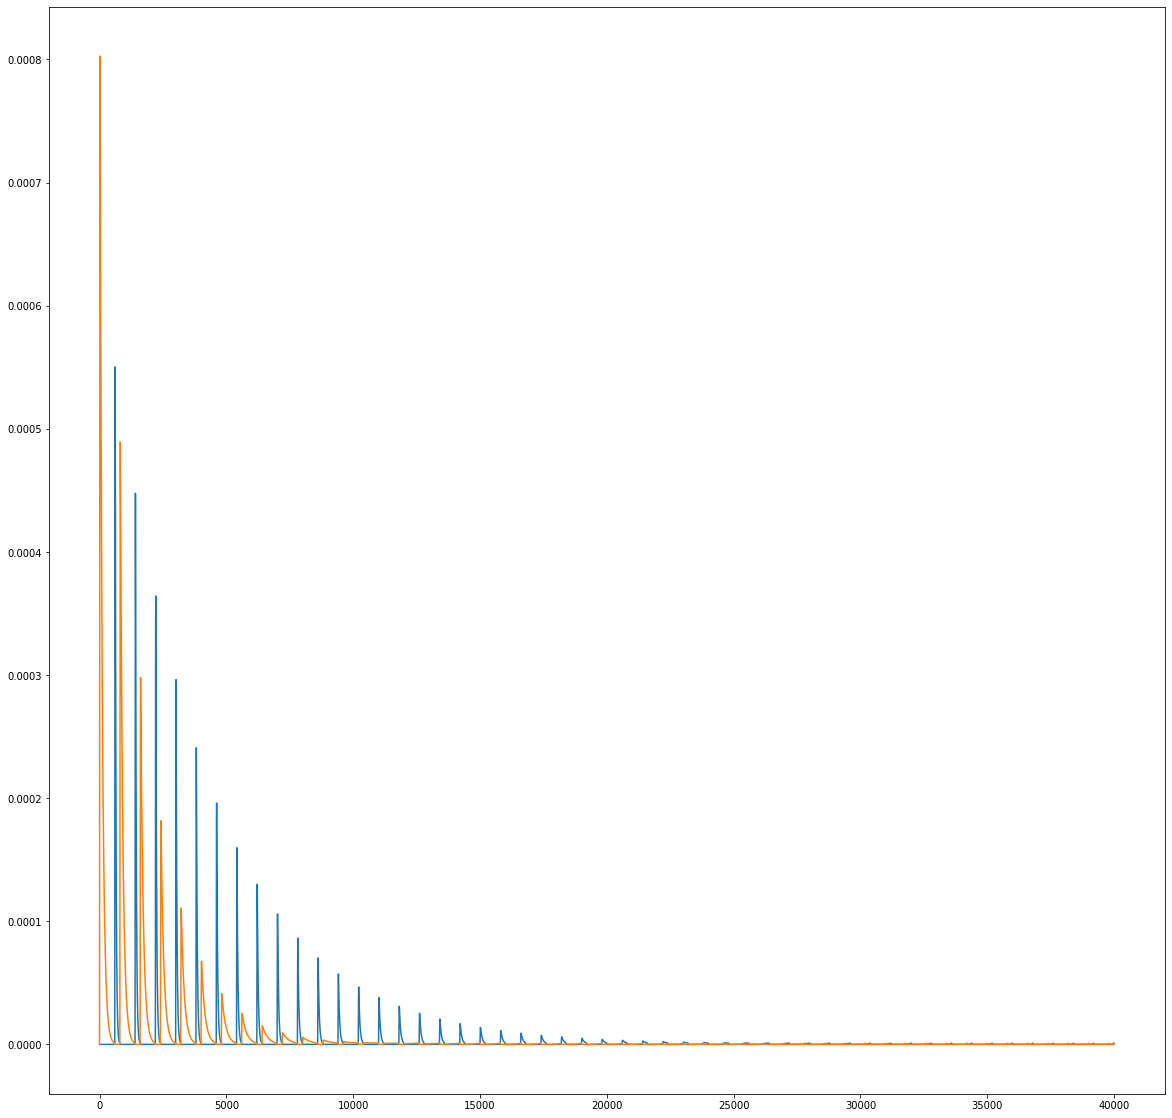

In [108]:
plt.figure(figsize=(20,20))
plt.plot(pose_lrs)
plt.plot(gaussians_lrs)
plt.show()

In [57]:
a = get_expon_lr_func(0.01, 1e-9, 20, 0, 1000)

In [58]:
k = [a(i) for i in range(1000)]

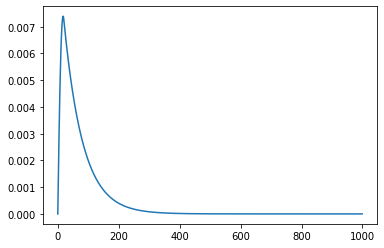

In [59]:
plt.plot(k)

In [16]:
import json
import torch

In [17]:
noise = {k: (torch.rand(7)*0.2).tolist() for k in range(38)}

In [9]:
with open('/mnt/sdb1/home/kbotashev/mip-nerf_projects/gaussian_splatting_original/output_old/tanks_temples_courtroom_colmap_pa-lr-0.0001adaptive_cam_choice/noise.json', 'w') as f:
    json.dump(noise, f)